# Forecast TDS9
Testa facebook prophet forecast modell på TDS9 data

## Ladda bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


## Läs in data
Tillgänglig data är från och med 2012-01-01 till och med 2019-01-31

In [44]:
df = pd.read_csv('data\TDS9-2013-01-01-2020-01-31.csv', sep=';', decimal=',', usecols= ['timestamp', 'property', 'consumption_value', 'temperature'])
df = df[df.property == 'energy']
df.head()

,timestamp,property,consumption_value,temperature
0,2013-01-02T00:00:00Z,energy,2.60,6.04042
1,2013-01-03T00:00:00Z,energy,2.75,4.33474
2,2013-01-04T00:00:00Z,energy,2.61,5.74339
3,2013-01-05T00:00:00Z,energy,2.96,2.56162
4,2013-01-06T00:00:00Z,energy,3.37,-0.28711


Ändra från timestamp sträng till datum och subtrahera med 366 för att få faktiskt datum (K2 skiftar TDS anläggningar med 1 år för att larmlistan i k2 ska ge några larm då den enbart räknar max 1 år relativt idag och inget nytt data tillkommer till TDS)

In [45]:
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=False) - pd.DateOffset(days=366)
df['timestamp'] = df['timestamp'].dt.tz_convert(None)

0      2012-01-02 00:00:00+00:00
1      2012-01-03 00:00:00+00:00
2      2012-01-04 00:00:00+00:00
3      2012-01-05 00:00:00+00:00
4      2012-01-06 00:00:00+00:00
                  ...           
2568   2019-01-27 00:00:00+00:00
2569   2019-01-28 00:00:00+00:00
2570   2019-01-29 00:00:00+00:00
2571   2019-01-30 00:00:00+00:00
2572   2019-01-31 00:00:00+00:00
Name: timestamp, Length: 2573, dtype: datetime64[ns, UTC]

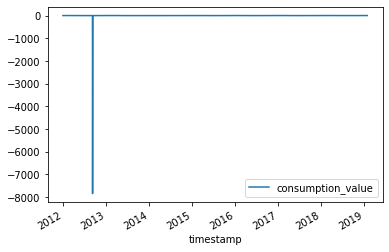

In [48]:
df.plot('timestamp', 'consumption_value')

Ta bort uppenbar outlier och interpolera värdet

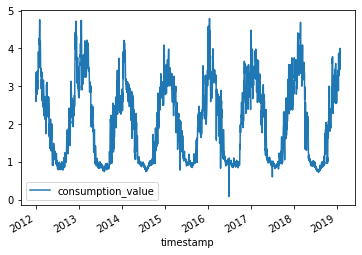

In [49]:
df.loc[df.consumption_value<-1000, 'consumption_value'] = np.nan
df.loc[:,'consumption_value'] = df.assign(consumption_value = df.consumption_value.interpolate(method='linear'))
df.plot('timestamp', 'consumption_value')

In [50]:
print(df.timestamp.min(), df.timestamp.max())

2012-01-02 00:00:00 2019-01-31 00:00:00


## Forecasting

Börjar med att förbereda data frame för prophet forecasting, datum kolumn måste heta ds och variabeln y.  
För prognostävlingen skall resultat utvärderas på senaste året vilket blir 2018, detta år exkluderas därför och 2017 används som testår och 2013-2016 som träningsår.  

In [51]:
def divide_into_train_and_test(df):
    train = df[df.ds <= '2016-12-31']
    test = df[(df.ds > '2016-12-31') & (df.ds<='2017-12-31')]
    return train, test

df_m = df[['timestamp', 'consumption_value']]
df_m.columns = ['ds', 'y']

train, test = divide_into_train_and_test(df_m)
test.head()

,ds,y
1821,2017-01-01,2.88
1822,2017-01-02,3.52
1823,2017-01-03,3.10
1824,2017-01-04,3.63
1825,2017-01-05,4.48


Träna default prophet modell

In [52]:
m = Prophet()
m.fit(train)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Visualisera resultat

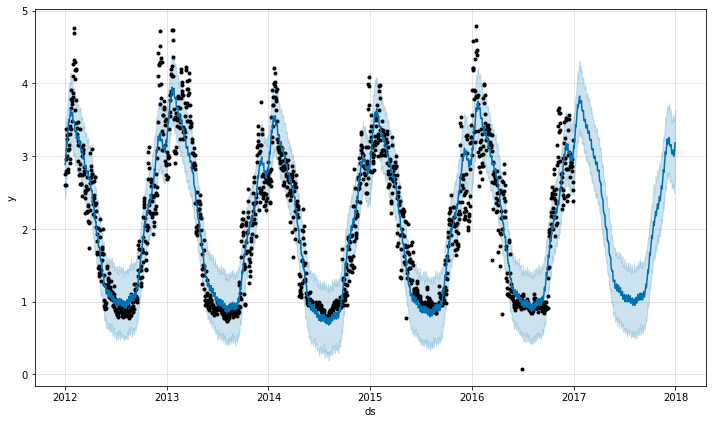

In [53]:
fig = m.plot(forecast)

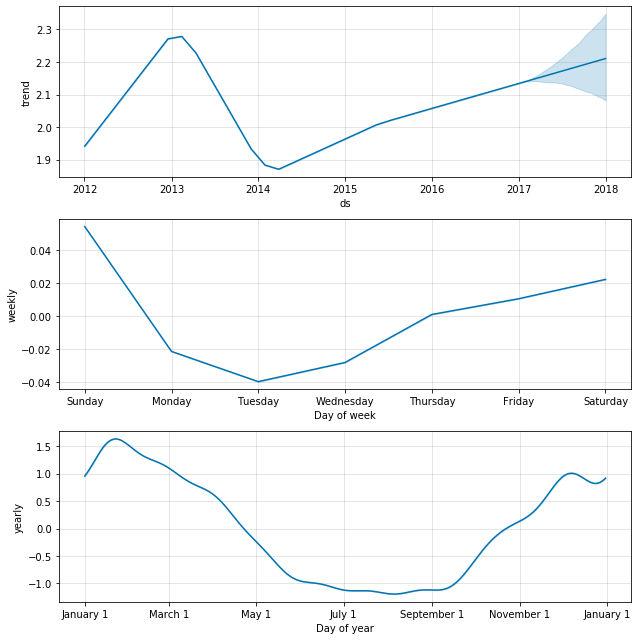

In [54]:
fig = m.plot_components(forecast)

### Beräkna fel  
RMSE och MAPE

In [55]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test.y, forecast.yhat[-365:], squared=False)

0.3494052833282225

In [56]:
import numpy as np

def mean_absolute_percentage_error(y_pred, y_true):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [57]:
mean_absolute_percentage_error(forecast.yhat[-365:], test.y)

14.972593929623681

### Plotta endast test period

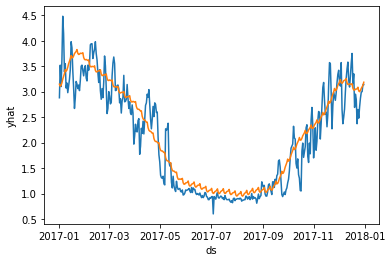

In [61]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2017-01-01'])

Weekly seasonality verkar lägga till onödig variation, testar att ta bort

In [59]:
m2 = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True)
m2.fit(train)

future2 = m2.make_future_dataframe(periods=365)
forecast2 = m2.predict(future2)

mean_absolute_percentage_error(forecast2.yhat[-365:], test.y)


15.314590909495074

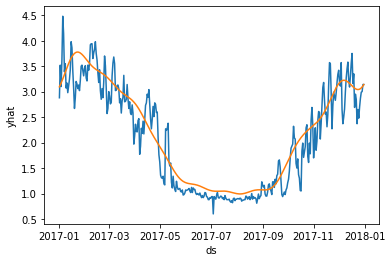

In [62]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast2[forecast2.ds>='2017-01-01'])

Ej lägre MAPE men ser rimligare ut

Titta på residualer

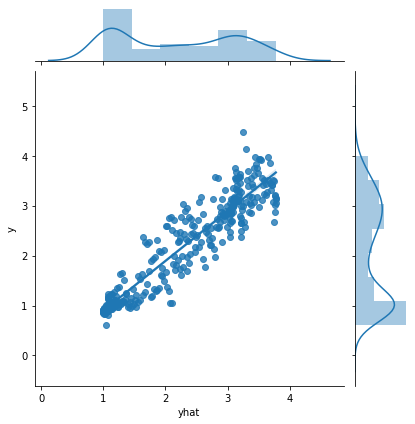

In [64]:
import seaborn as sns

df_merged = df_m.merge(forecast2[['ds', 'yhat']], left_on='ds', right_on='ds')
sns.jointplot("yhat", "y", data=df_merged[df_merged.ds >= '2017-01-01'], kind="reg")


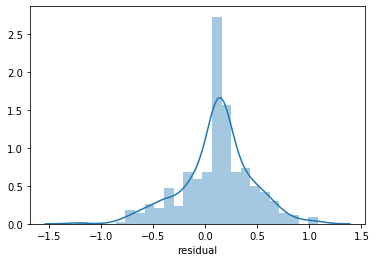

In [65]:
df_merged['residual'] = df_merged.yhat - df_merged.y

sns.distplot(df_merged[df_merged.ds >= '2017-01-01']['residual'])

## Temperatur som extra regressor

In [66]:
df_m_temp = df[['timestamp', 'consumption_value', 'temperature']]
df_m_temp.columns = ['ds', 'y', 'temp']

train, test = divide_into_train_and_test(df_m_temp)

m_temp = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True,
            ).add_regressor('temp', prior_scale=0.5, mode = 'multiplicative')

m_temp.fit(train)

future_temp = m_temp.make_future_dataframe(periods=365)
future_temp['temp'] = df_m_temp['temp']

forecast_temp = m_temp.predict(future_temp)

mean_absolute_percentage_error(forecast_temp.yhat[-365:], test.y)


11.822119850355218

MAPE minskar från 15.4 till 11.9

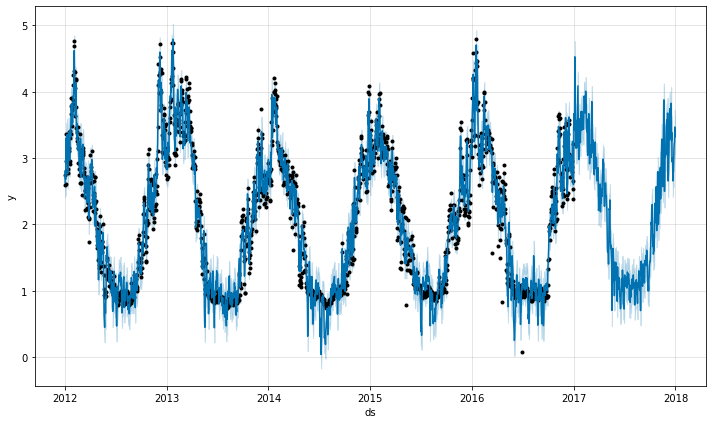

In [67]:
f = m_temp.plot(forecast_temp)

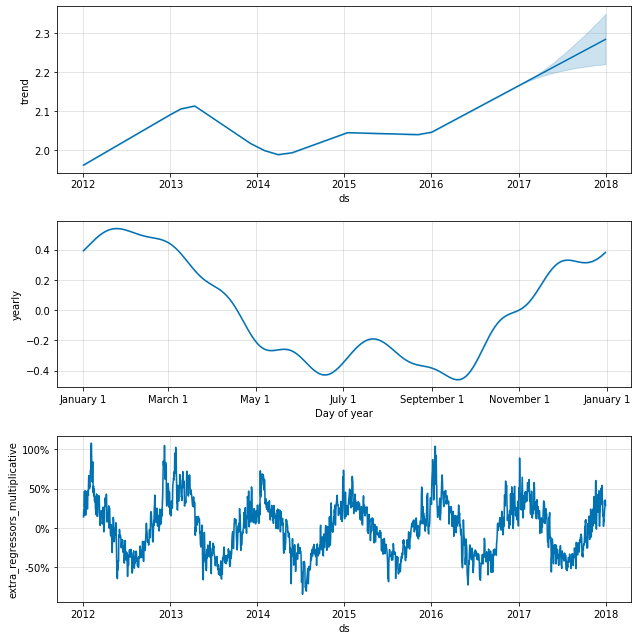

In [68]:
fig = m_temp.plot_components(forecast_temp)

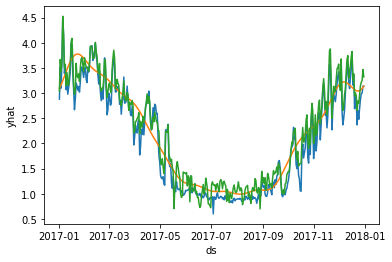

In [70]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast2[forecast2.ds>='2017-01-01'])
sns.lineplot(x = 'ds', y = 'yhat', data=forecast_temp[forecast_temp.ds>='2017-01-01'])


Kan modellen förbätras med en extra regressor för temperaturer under 15C? Detta då det ickelinjära förhållandet är som starkast kring brytpunkten vid 15C

In [71]:
df_m_temp['temp_below_15'] = (df_m_temp.temp < 15).astype('int')

train, test = divide_into_train_and_test(df_m_temp)

m_temp2 = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True
            ).add_regressor('temp', prior_scale=0.1, mode = 'multiplicative'
            ).add_regressor('temp_below_15', prior_scale=0.9, mode = 'multiplicative')

m_temp2.fit(train)



future_temp2 = m_temp2.make_future_dataframe(periods=365)
future_temp2['temp'] = df_m_temp['temp']
future_temp2['temp_below_15'] = df_m_temp['temp_below_15']

forecast_temp2 = m_temp2.predict(future_temp2)

mean_absolute_percentage_error(forecast_temp2.yhat[-365:], test.y)


10.60472481239129

MAPE minskad med ca 1% efter tillägg av dummy regressor

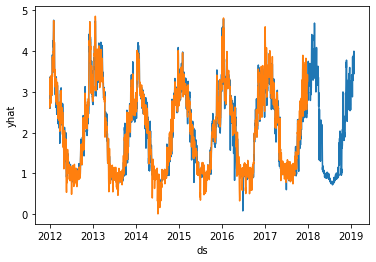

In [72]:
sns.lineplot(x = 'ds', y = 'y', data=df_m_temp)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast_temp2)

Trots minskat fel ser inte dummy regressorn ut att ha löst problemet med den för stora variationen för sommarmånaderna

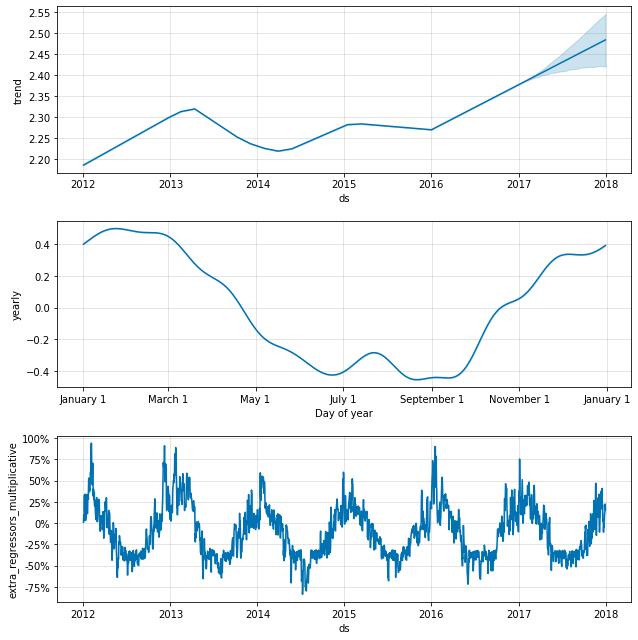

In [73]:
fig = m_temp2.plot_components(forecast_temp2)

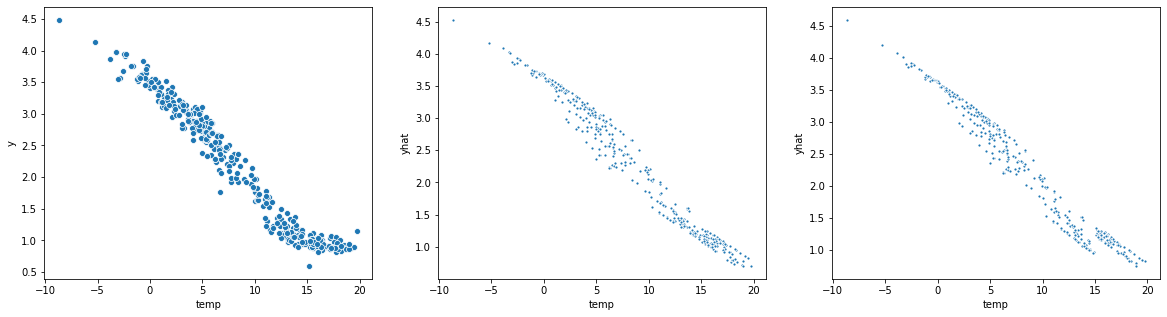

In [74]:
axes = plt.subplots(1,3, figsize=(20,5))
sns.scatterplot(x = 'temp', y = 'y', data=test, ax = axes[1][0])
sns.scatterplot(test.temp, y = forecast_temp[forecast_temp.ds>='2017-01-01'].yhat, marker='.', ax = axes[1][1])
sns.scatterplot(test.temp, y = forecast_temp2[forecast_temp2.ds>='2017-01-01'].yhat, marker='.', ax = axes[1][2])

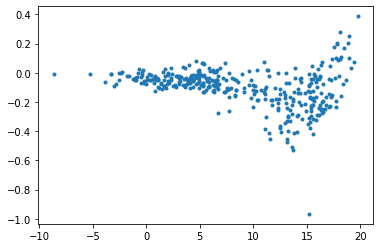

In [312]:
res_p = (test.y - forecast_temp[forecast_temp.ds>='2017-01-01'].yhat)/test.y

plt.plot(test.temp, res_p, '.')

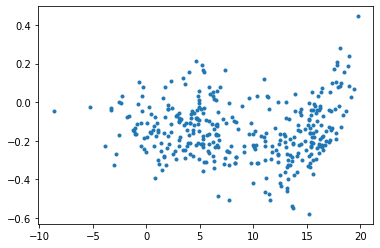

In [313]:
res = (test.y - forecast_temp[forecast_temp.ds>='2017-01-01'].yhat)

plt.plot(test.temp, res, '.')

Liten skillnad mellan modellerna med och utan dummy variabel, ser dock fortsatt linjärt ut

## Transformera temperatur regressor
Då förhållandet temperatur-energi är icke linjärt vill jag testa om det går att transformera temperatur till ett mer linjärt förhållande.

Det största problemet ligger som sagt vid 15C, om detta kan korrigeras till mer linjärt förhållande kanske forecast kan förbättras för sommarmånaderna. Det icke linjära förhållandet verkar inte påverka prognosen lika mycket då energiförbrukningen är högre.

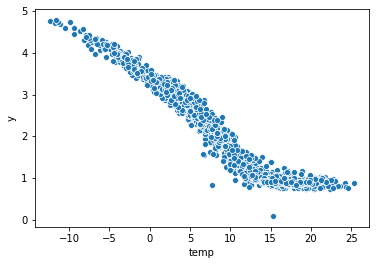

In [75]:
sns.scatterplot(x = 'temp', y = 'y', data=train)

Som första test konverterar jag till Kelvin för att kringå problemet med negativa och positiva värden samt normaliserar på min och 15 grader varefter jag sätter alla normaliserade värden över 1 till 1 (motsvarande alla temperaturer över 15C sätts till 15C)

In [392]:
df_m_temp['temp_K'] = df_m_temp.temp+273.15
df_m_temp['temp_K_norm'] = ((df_m_temp.temp_K-df_m_temp.temp_K.min())/((15+273.15)-df_m_temp.temp_K.min())).clip(upper=1)

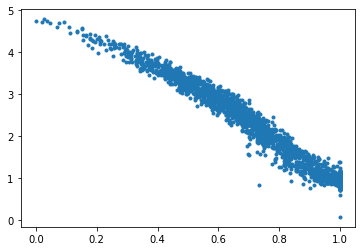

In [77]:
plt.plot(df_m_temp.temp_K_norm, df_m_temp.y, '.')

In [78]:
train, test = divide_into_train_and_test(df_m_temp)

m_temp_trans = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True
            ).add_regressor('temp_K_norm', prior_scale=0.5, mode = 'multiplicative')

m_temp_trans.fit(train)

future_temp_trans = m_temp_trans.make_future_dataframe(periods=365)
future_temp_trans['temp_K_norm'] = df_m_temp['temp_K_norm']

forecast_temp_trans = m_temp_trans.predict(future_temp_trans)

mean_absolute_percentage_error(forecast_temp_trans.yhat[-365:], test.y)

7.710728277688671

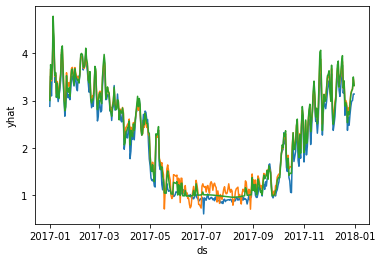

In [80]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast_temp[forecast_temp.ds>='2017-01-01'])
sns.lineplot(x = 'ds', y = 'yhat', data=forecast_temp_trans[forecast_temp_trans.ds>='2017-01-01'])

Felet minskar med 3% och modellen är dominerad av tidsserie komponent för sommarmånaderna.  
Tittar man på komponenterna för modellen kan vi se att för extra regressor är de som avklippta för höga temperaturer. Kanske blir resultatet rimligare om man istället för att abrupt klippa temperaturer vid 15C att istället gör ett mjukare avslut.

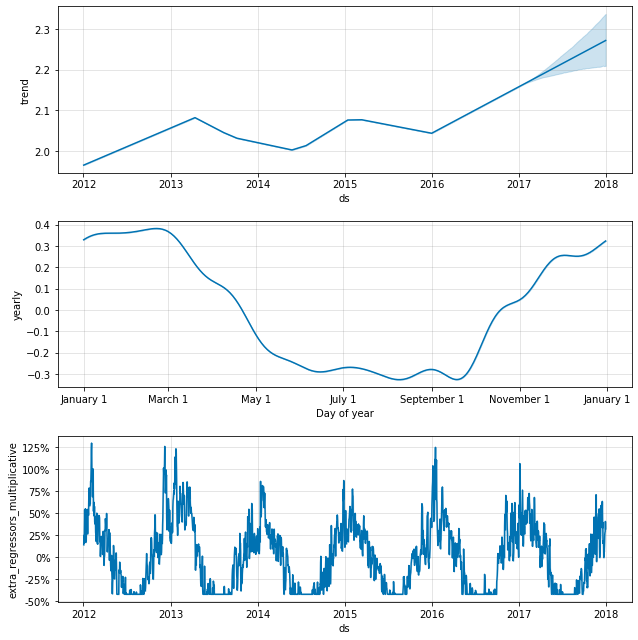

In [81]:
fig = m_temp_trans.plot_components(forecast_temp_trans)

Istället för att sätta alla normaliserade värden över 1 till 1 så minskar jag normaliserade värden över 1 med 20% (godtyckligt) för att behålla en del av temperaturberoendet men ändå minska det för varmare temperaturer.

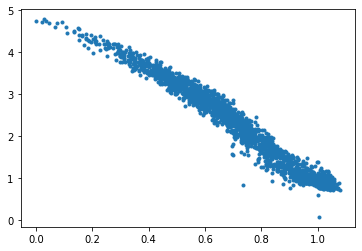

In [82]:
def transform_temperature(t):
    temp_K = t + 273.15
    temp_K_norm = ((temp_K-temp_K.min())/((15+273.15)-temp_K.min()))#.clip(upper=1)
    temp_K_norm[temp_K_norm>1] = 1 + (temp_K_norm[temp_K_norm>1]-1)*0.2
    return temp_K_norm

df_m_temp['temp_trans'] = transform_temperature(df_m_temp.temp)

plt.plot(df_m_temp.temp_trans, df.consumption_value, '.')

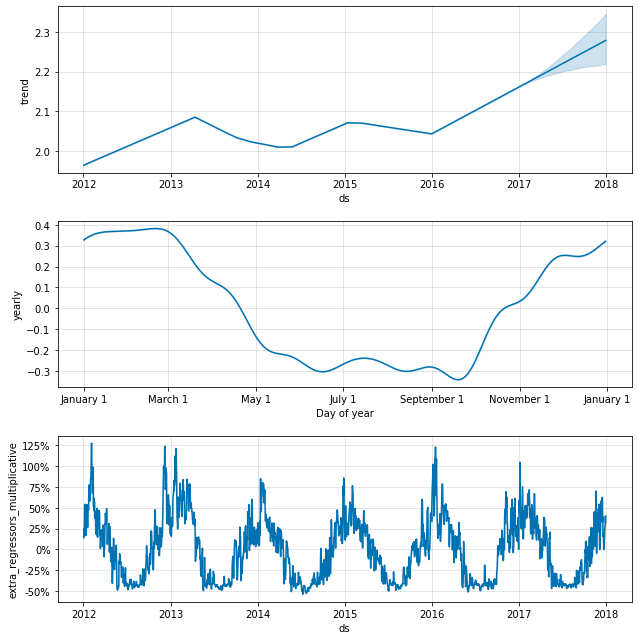

In [83]:
train, test = divide_into_train_and_test(df_m_temp)

m_temp_trans2 = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True
             ).add_regressor('temp_trans', prior_scale=0.5, mode = 'multiplicative')
m_temp_trans2.fit(train)

future_tt = m_temp_trans2.make_future_dataframe(periods=365)
future_tt['temp_trans'] = df_m_temp['temp_trans']

forecast_tt = m_temp_trans2.predict(future_tt)

fig = m_temp_trans2.plot_components(forecast_tt)

In [84]:
mean_absolute_percentage_error(forecast_tt.yhat[-365:], test.y)

8.452606647423739

Något högre fel än men resultatet ser rimligare ut

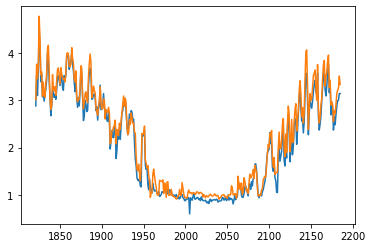

In [85]:
plt.plot(test.y)
plt.plot(forecast_tt.yhat[-365:])
#plt.plot(forecast_temp_trans.yhat[-365:])

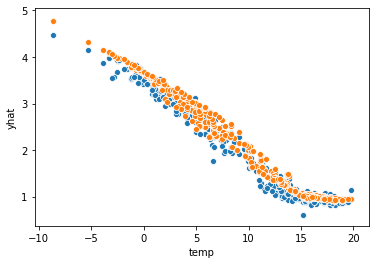

In [86]:
#sns.scatterplot(x='temp', y='y', data=train)
sns.scatterplot(x='temp', y='y', data=test)

sns.scatterplot(x=test.temp, y=forecast_tt.yhat[-365:])

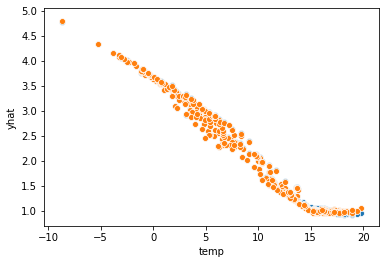

In [87]:
sns.scatterplot(x=test.temp, y=forecast_tt.yhat[-365:])
sns.scatterplot(x=test.temp, y=forecast_temp_trans.yhat[-365:])

(0.8, 1.2)

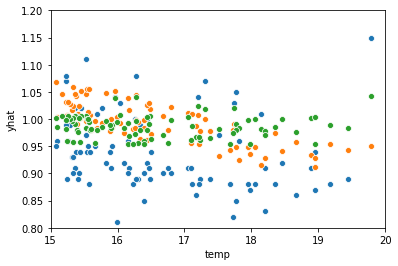

In [88]:
sns.scatterplot(x='temp', y='y', data=test)
sns.scatterplot(x=test.temp, y=forecast_tt.yhat[-365:])
ax =sns.scatterplot(x=test.temp, y=forecast_temp_trans.yhat[-365:])
ax.set_xlim(15,20)
ax.set_ylim(0.8,1.2)


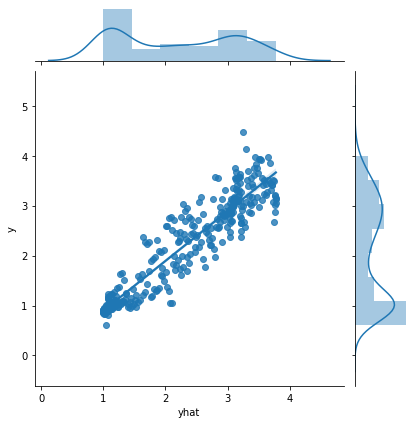

In [302]:
df_merged_temp = df_m_temp.merge(forecast_tt[['ds', 'yhat']], left_on='ds', right_on='ds')
df_merged_temp = df_merged_temp.merge(forecast_temp_trans[['ds', 'yhat']], left_on='ds', right_on='ds', suffixes=['', '_clip'])
df_merged_temp['residual'] = (df_merged_temp.y-df_merged_temp.yhat)/df_merged_temp.y
df_merged_temp['residual_clip'] = (df_merged_temp.y-df_merged_temp.yhat_clip)/df_merged_temp.y

sns.jointplot("yhat", "y", data=df_merged[df_merged.ds >= '2017-01-01'], kind="reg")

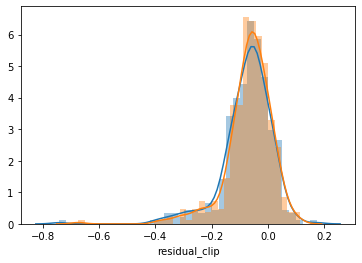

In [303]:
sns.distplot(df_merged_temp[(df_merged_temp.ds<='2017-12-31') & (df_merged_temp.ds > '2016-12-31')]['residual'])
sns.distplot(df_merged_temp[(df_merged_temp.ds<='2017-12-31') & (df_merged_temp.ds > '2016-12-31')]['residual_clip'])

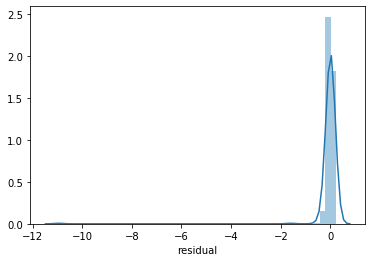

In [304]:
sns.distplot(df_merged_temp[(df_merged_temp.ds<='2016-12-31') & (df_merged_temp.ds > '2015-12-31')]['residual'])

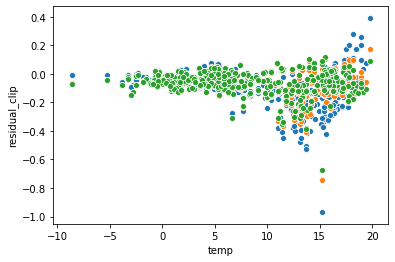

In [315]:
sns.scatterplot(test.temp, res_p)
sns.scatterplot(x='temp', y='residual', data=df_merged_temp[df_merged_temp.ds > '2016-12-31'])
sns.scatterplot(x='temp', y='residual_clip', data=df_merged_temp[df_merged_temp.ds > '2016-12-31'])


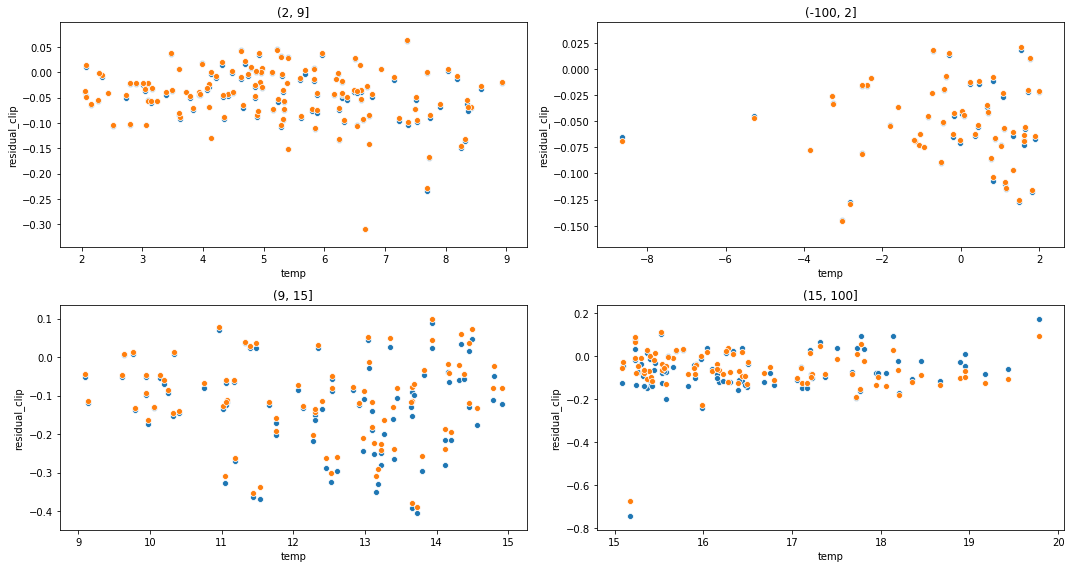

In [306]:
df_merged_temp['Interval'] = pd.cut(df_merged_temp['temp'], [-100, 2, 9, 15, 100])

intervals = df_merged_temp.Interval.unique()
fig, axes = plt.subplots(2,2, figsize=(15,8))
for i, ax in enumerate(axes.flat):
    d = df_merged_temp[(df_merged_temp.ds > '2016-12-31') & (df_merged_temp.Interval == intervals[i])]
    sns.scatterplot(x='temp', y='residual', data=d, ax = ax)
    sns.scatterplot(x='temp', y='residual_clip', data=d, ax = ax)
    ax.set(title = intervals[i])
    
plt.tight_layout()

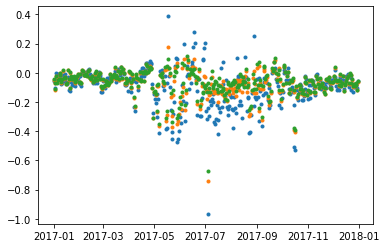

In [307]:
df_merged_temp = df_merged_temp.merge(forecast_temp[['ds', 'yhat']], left_on='ds', right_on='ds', suffixes=['', '_orig'])
df_merged_temp['residual_orig'] = (df_merged_temp.y - df_merged_temp.yhat_orig)/df_merged_temp.y

ev_df = df_merged_temp[(df_merged_temp.ds<='2017-12-31') & (df_merged_temp.ds > '2016-12-31')]
plt.plot(ev_df.ds, ev_df.residual_orig, '.')
plt.plot(ev_df.ds, ev_df.residual, '.')
plt.plot(ev_df.ds, ev_df.residual_clip, '.')

#ax = sns.scatterplot(x='ds', y='residual_clip', data=ev_df)
#ax.set_xlim(ev_df.ds.min(), ev_df.ds.max())

Tittar man på residualerna så verkar inte den mjuka övergången vid 15C ge någon större förbättring, snarare försämring för de lägre temperaturintervallerna. Med tanke på att även felet var lägre vore det korrekt att i fortsättningen använda den abrupt trunkerade temperaturskalan.

## Mindre historisk data

In [421]:
train, test = divide_into_train_and_test(df_m_temp)
train_short = train[train.ds>'2014-12-31']

m_temp_trans_short = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True
            ).add_regressor('temp_K_norm', prior_scale=0.5, mode = 'multiplicative')

m_temp_trans_short.fit(train_short)

future_temp_trans2 = m_temp_trans_short.make_future_dataframe(periods=365).merge(df_m_temp[df_m_temp.ds > '2014-12-31'][['ds', 'temp_K_norm']], on='ds', how='left')

forecast_temp_trans2 = m_temp_trans_short.predict(future_temp_trans2)

mean_absolute_percentage_error(forecast_temp_trans2.yhat[-365:], test.y)

11.905596876853123

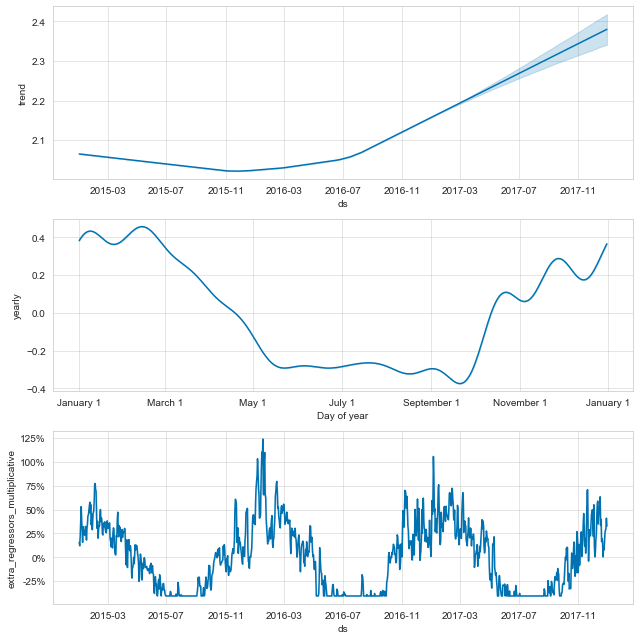

In [422]:
fig = m_temp_trans_short.plot_components(forecast_temp_trans2)

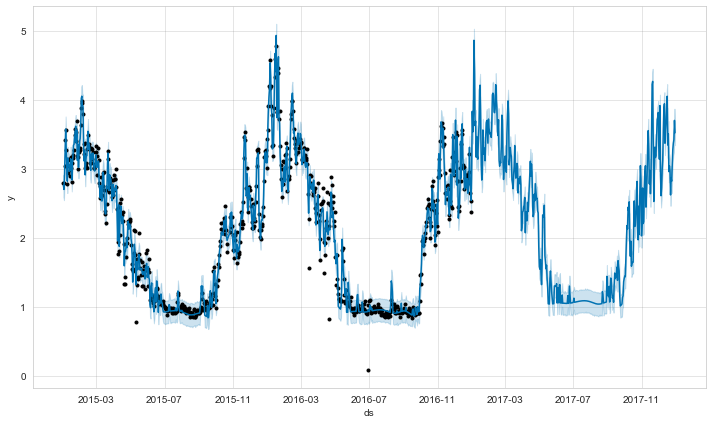

In [423]:
f = m_temp_trans_short.plot(forecast_temp_trans2)

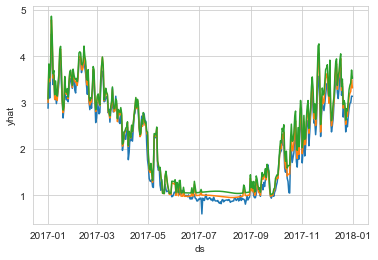

In [424]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast_temp_trans[forecast_temp.ds>='2017-01-01'])
sns.lineplot(x = 'ds', y = 'yhat', data=forecast_temp_trans2[forecast_temp_trans2.ds>='2017-01-01'])

## Mer väderdata

In [277]:
weather = pd.read_csv('data/ESGG.txt', low_memory= False)
weather['valid'] = pd.to_datetime(weather['valid']) 
weather.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,...,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar
0,ESGG,2012-01-01 06:20:00,32.0,32.0,100.00,150.0,14.0,NaN,29.53,NaN,...,NaN,-DZ BR,NaN,NaN,NaN,NaN,NaN,NaN,21.16,ESGG 010620Z 15014KT 3400 -DZ BR OVC003 00/M00...
1,ESGG,2012-01-01 06:50:00,32.0,32.0,100.00,150.0,14.0,NaN,29.50,NaN,...,NaN,RA,NaN,NaN,NaN,NaN,NaN,NaN,21.16,ESGG 010650Z 15014KT 2400 RA OVC003 00/M00 Q09...
2,ESGG,2012-01-01 07:20:00,32.0,32.0,100.00,160.0,16.0,NaN,29.50,NaN,...,NaN,-RASN,NaN,NaN,NaN,NaN,NaN,NaN,20.42,ESGG 010720Z 16016KT 3900 -RASN OVC003 00/00 Q...
3,ESGG,2012-01-01 07:50:00,33.8,32.0,93.03,160.0,17.0,NaN,29.47,NaN,...,NaN,-RA,NaN,NaN,NaN,NaN,NaN,NaN,22.43,ESGG 010750Z 16017KT 7000 -RA OVC003 01/00 Q09...
4,ESGG,2012-01-01 08:20:00,33.8,33.8,100.00,170.0,12.0,NaN,29.50,NaN,...,NaN,-RA,NaN,NaN,NaN,NaN,NaN,NaN,24.29,ESGG 010820Z 17012KT 6000 -RA OVC004 01/01 Q09...


nans

In [278]:
completeness = round(100*weather.isna().sum()/len(weather), 2)
completeness[list(completeness[completeness < 1.].index)]
#date         tmpc  dwpc  relh  drct  sknt  alti  vsby


station    0.00
valid      0.00
tmpf       0.04
dwpf       0.04
relh       0.12
sknt       0.02
p01i       0.71
alti       0.02
vsby       0.05
feel       0.12
metar      0.00
dtype: float64

In [263]:
#weather = weather.dropna(subset=['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'alti', 'vsby', 'feel'], how='all')
#completeness = weather.isna().sum()
#completeness[list(completeness[completeness < len(weather)].index)]

station         0
valid           0
tmpf           26
dwpf           27
relh          124
drct         1855
sknt            4
p01i          847
alti           11
vsby           39
gust       119304
skyc1       41654
skyc2       93000
skyc3      114276
skyc4      120263
skyl1       43818
skyl2       94096
skyl3      115539
skyl4      121541
wxcodes     91582
feel          124
metar           0
dtype: int64

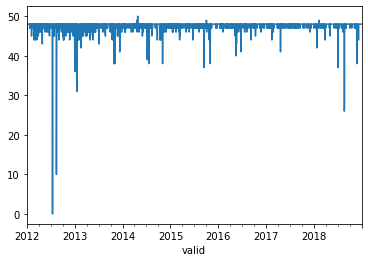

In [279]:
weather.resample('D', on='valid').count()['valid'].plot()

In [280]:
print(weather.resample('D', on='valid').count()['valid'].mode(), weather.resample('D', on='valid').count()['valid'].mean())

0    48
dtype: int64 47.561815336463226


De flesta dagar består av 48 mätningar

In [281]:
weather = weather[list(completeness[completeness < 1.].index)]
weather = weather.resample('D', on='valid').mean()
weather.isna().sum()

tmpf     1
dwpf     1
relh     3
sknt     1
p01i    19
alti     1
vsby     1
feel     3
dtype: int64

In [287]:
weather = weather.interpolate(method='linear')
weather.isna().sum()

tmpf    0
dwpf    0
relh    0
sknt    0
alti    0
vsby    0
feel    0
dtype: int64

In [285]:
weather.p01i.dropna().sum()

0.0

In [286]:
weather = weather.drop(columns = ['p01i'])

Variabel förklaring

* station: three or four character site identifier
* valid: timestamp of the observation (UTC)
* tmpf: Air Temperature in Fahrenheit, typically @ 2 meters
* dwpf: Dew Point Temperature in Fahrenheit, typically @ 2 meters
* relh: Relative Humidity in %
* drct: Wind Direction in degrees from north
* sknt: Wind Speed in knots
* alti: Pressure altimeter in inches
* vsby: Visibility in miles

dew point relaterar till luftfuktigheten

Konvertera från Farenheit till Celsius

In [288]:
def F_to_C(f):
    return (f-32.)/1.8

weather['tmpc'] = weather['tmpf'].apply(F_to_C)

Vilka variabler är korrelerade?

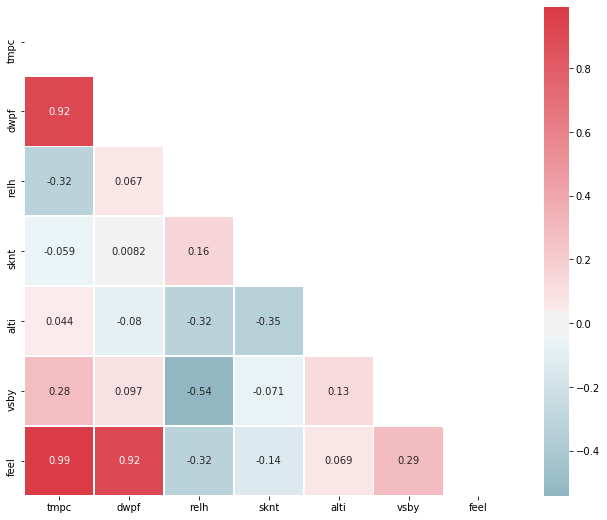

In [289]:
d = weather[['tmpc', 'dwpf', 'relh', 'sknt', 'alti', 'vsby', 'feel']]
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, center=0, cmap=cmap,mask = mask,
            square=True, linewidths=.5, annot=True)

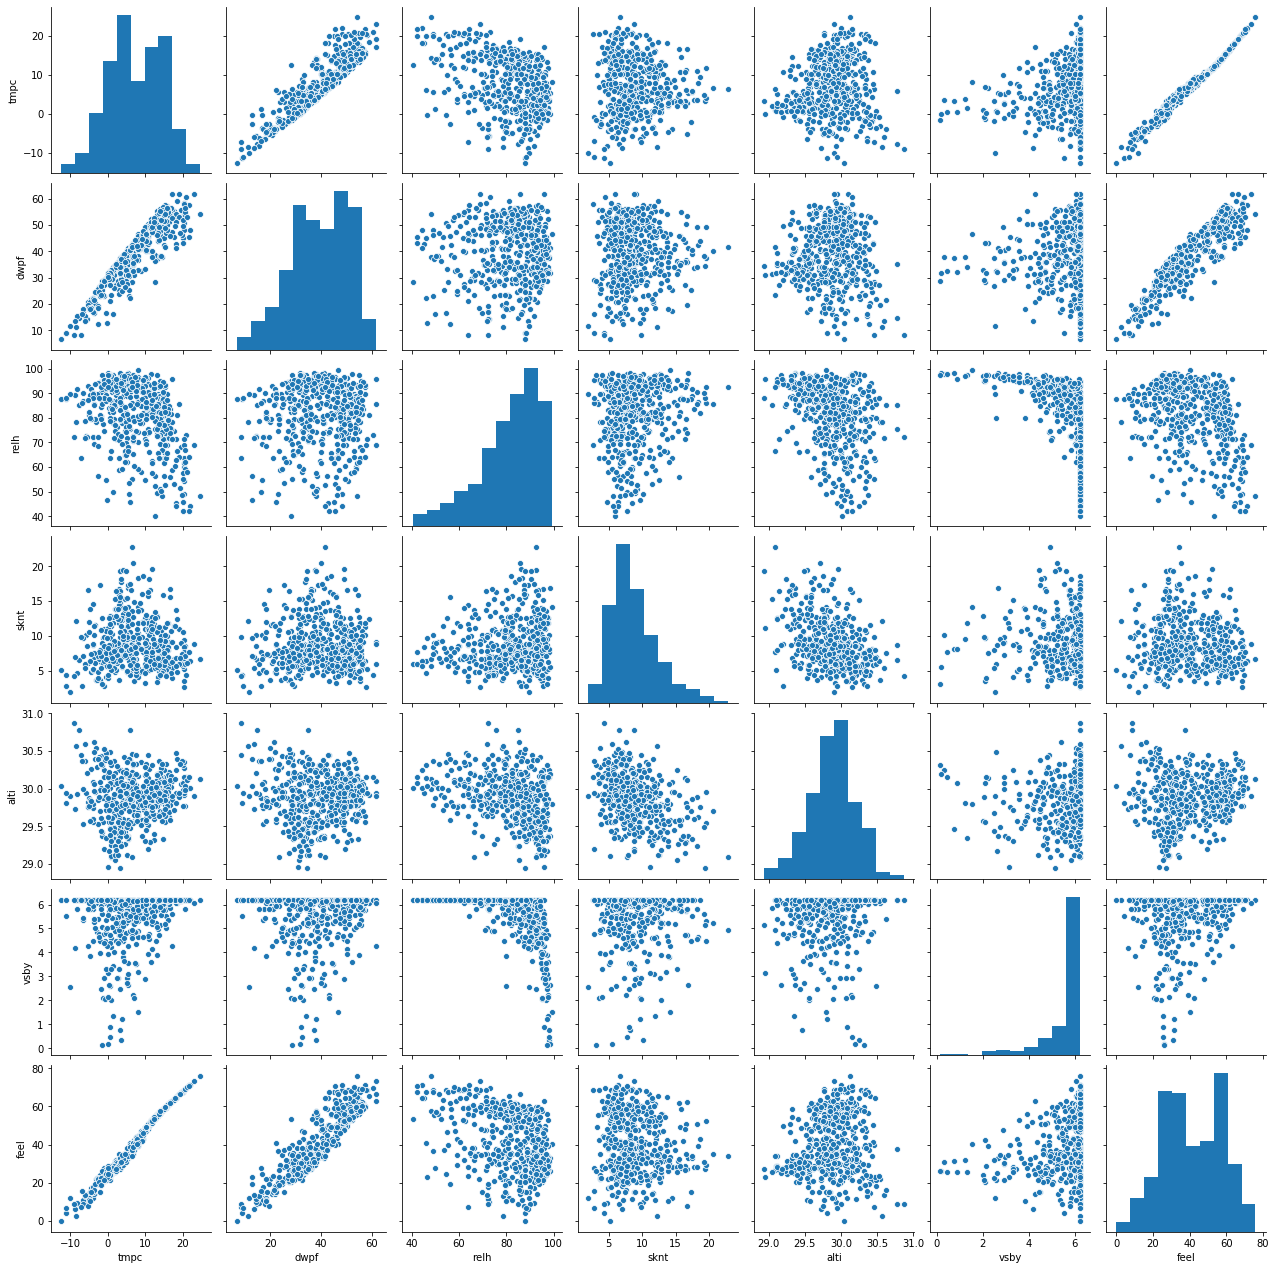

In [290]:
sns.pairplot(d.sample(500))

feel och dwpf har hög korrelation med temperatur, för en modell där vi vill kunna förklara konsumtion med prediktorer bör dessa exkluderas, i detta fall är vi dock främst intresserade av att få en bra prognos och ej av att kunna förklara effekter av specifika prediktorer.
"Having correlated predictors is not really a problem for forecasting, as we can still compute forecasts without needing to separate out the effects of the predictors." (https://otexts.com/fpp2/causality.html)

In [291]:
weather = weather.reset_index()

In [427]:
weather.to_csv('data/ESGG_mod.csv')

In [292]:
df_merged_weather = df_m_temp.merge(weather, left_on='ds', right_on='valid', how='left')
df_merged_weather.head()

,ds,y,temp,temp_below_15,temp_K,temp_K_norm,temp_trans,valid,tmpf,dwpf,relh,sknt,alti,vsby,feel,tmpc
0,2012-01-02,2.60,6.04042,1,279.19042,0.672679,0.672679,2012-01-02,40.212500,38.71250,94.393333,11.833333,29.416250,5.914167,32.558333,4.562500
1,2012-01-03,2.75,4.33474,1,277.48474,0.610365,0.610365,2012-01-03,36.875000,34.36250,90.665000,17.458333,29.250625,5.029792,26.489583,2.708333
2,2012-01-04,2.61,5.74339,1,278.89339,0.661827,0.661827,2012-01-04,39.575000,33.87500,80.441458,21.750000,28.915625,5.598750,29.035833,4.208333
3,2012-01-05,2.96,2.56162,1,275.71162,0.545588,0.545588,2012-01-05,33.917391,32.03913,92.788043,11.152174,28.712174,5.797391,24.963696,1.065217
4,2012-01-06,3.37,-0.28711,1,272.86289,0.441515,0.441515,2012-01-06,28.840000,24.12000,82.662667,6.777778,29.586222,6.210000,21.352889,-1.755556


In [428]:
weather.columns

Index(['valid', 'tmpf', 'dwpf', 'relh', 'sknt', 'alti', 'vsby', 'feel',
       'tmpc'],
      dtype='object')

Är temperatur från TDS filen liknande temperatur från Landvetter?

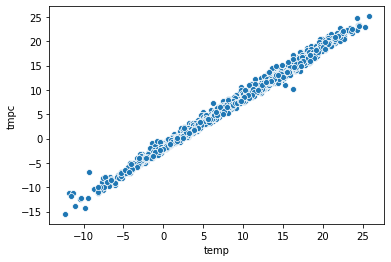

In [293]:
sns.scatterplot(x = 'temp', y = 'tmpc', data = df_merged_weather[df_merged_weather.ds <= '2019-12-31'])

In [426]:
df_merged_weather['y'].corr(df_merged_weather['temp'])

-0.9695070756326516

Temperaturer har ett linjärt förhållande och borde därför vara tillräckligt lika. Jag antar därför att övriga väderparametrar från Landvetter borde vara relevanta för TDS9.

Hur korrelerar väderparametrar mot konsumtion?

C:\Users\idalu\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
C:\Users\idalu\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
C:\Users\idalu\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
C:\Users\idalu\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
C:\Users\idalu\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
C:\Users\idalu\Anaconda3\lib\site-packag

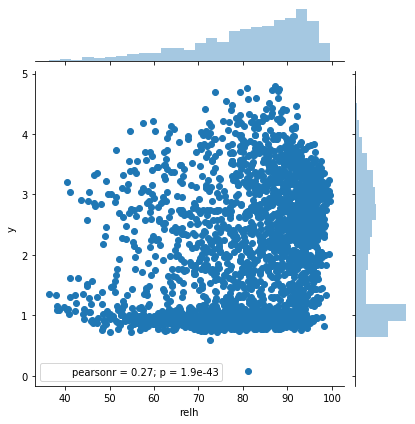

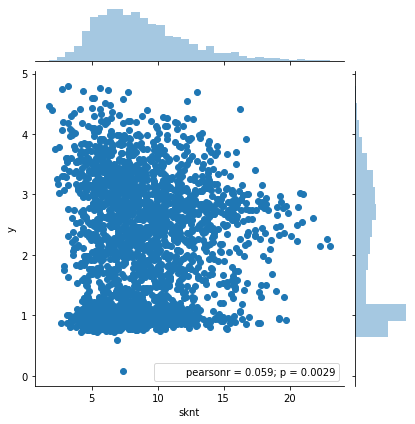

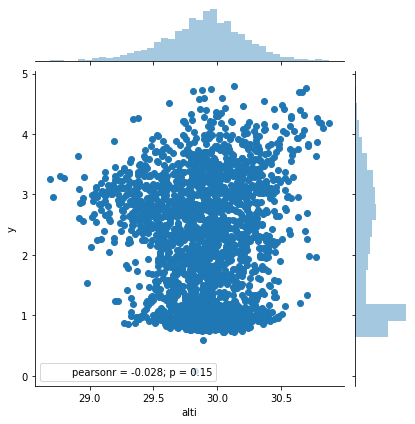

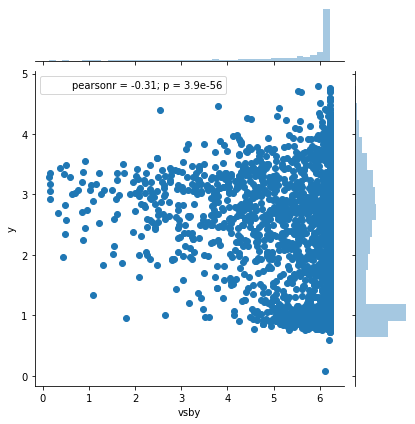

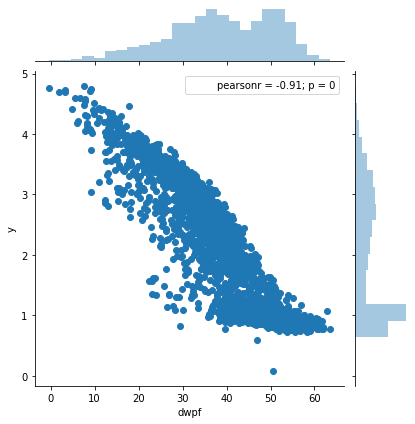

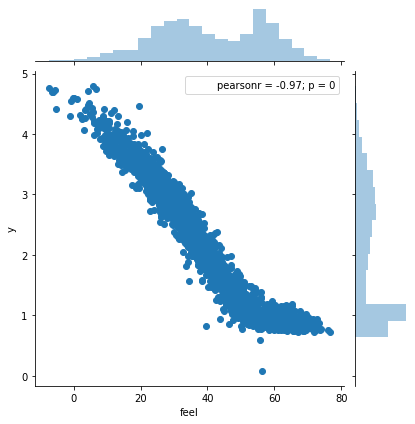

In [294]:
import scipy.stats as stats

sns.jointplot(x = 'relh', y='y', data=df_merged_weather).annotate(stats.pearsonr)
sns.jointplot(x = 'sknt', y='y', data=df_merged_weather).annotate(stats.pearsonr)
sns.jointplot(x = 'alti', y='y', data=df_merged_weather).annotate(stats.pearsonr)
sns.jointplot(x = 'vsby', y='y', data=df_merged_weather).annotate(stats.pearsonr)
sns.jointplot(x = 'dwpf', y='y', data=df_merged_weather).annotate(stats.pearsonr)
sns.jointplot(x = 'feel', y='y', data=df_merged_weather).annotate(stats.pearsonr)

Väldigt låg korrelation för 4 första variabler, relativ luftfuktighet har högst korrelation på 0.27. Hög korrelation mot feel och dwpf då de i sin tur även korrelerar med temperatur, effektsignaturen syns tydligt mot dessa två variabler, frågan är om de kan förbättra prognosen.

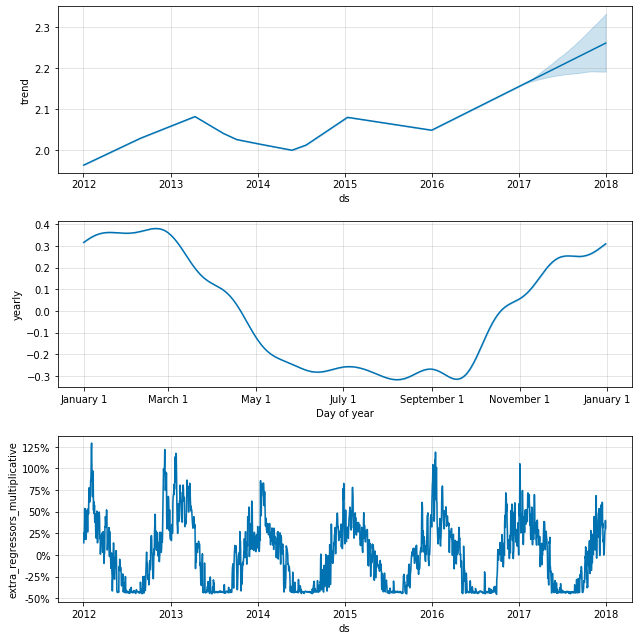

In [300]:
train, test = divide_into_train_and_test(df_merged_weather)

m_weather_all = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True
             ).add_regressor('temp_K_norm', prior_scale=0.5, mode = 'multiplicative'
            ).add_regressor('dwpf', prior_scale=0.5, mode = 'multiplicative'
            ).add_regressor('relh', prior_scale=0.5, mode = 'multiplicative'
            ).add_regressor('sknt', prior_scale=0.5, mode = 'multiplicative'
            ).add_regressor('alti', prior_scale=0.5, mode = 'multiplicative'
            ).add_regressor('vsby', prior_scale=0.5, mode = 'multiplicative'
            ).add_regressor('feel', prior_scale=0.5, mode = 'multiplicative')

m_weather_all.fit(train)

future = m_weather_all.make_future_dataframe(periods=365)

future['temp_K_norm'] = df_merged_weather['temp_K_norm']
future['dwpf'] = df_merged_weather['dwpf']
future['relh'] = df_merged_weather['relh']
future['sknt'] = df_merged_weather['sknt']
future['alti'] = df_merged_weather['alti']
future['vsby'] = df_merged_weather['vsby']
future['feel'] = df_merged_weather['feel']

forecast = m_weather_all.predict(future)

fig = m_weather_all.plot_components(forecast)

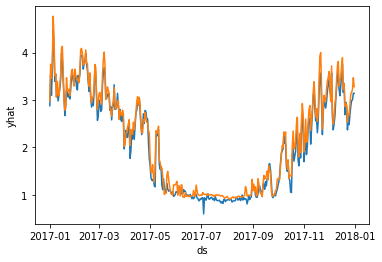

In [301]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2017-01-01'])

In [318]:
mape_all = mean_absolute_percentage_error(forecast[forecast.ds>='2017-01-01'].yhat, test.y)
mape_all

7.326422006081788

Testa att ta bort väder variabler en och en för att få en uppfattning om deras inflytande

In [380]:
def prophet_with_vars(var_list, error = 'MAPE'):
    m_weather = Prophet(growth = 'linear', 
                        weekly_seasonality = False,
                        daily_seasonality = False,
                        yearly_seasonality = True)
    for i in range(len(var_list)):
        m_weather = m_weather.add_regressor(var_list[i], prior_scale=0.5, mode = 'multiplicative')
    
    m_weather.fit(train)
    
    future = m_weather.make_future_dataframe(periods=365)
    
    for v in var_list:
        future[v] = df_merged_weather[v]
    
    forecast = m_weather.predict(future)
    if error ==  'MAPE':
        return mean_absolute_percentage_error(forecast[forecast.ds>='2017-01-01'].yhat, test.y)
    elif error == 'RMSE':
        return mean_squared_error(test.y, forecast[forecast.ds>='2017-01-01'].yhat, squared=False)

In [ ]:
mapes = []

var_list_all = ['temp_K_norm', 'dwpf', 'relh', 'sknt', 'alti', 'vsby', 'feel']

for v in var_list_all:
    mapes.append(prophet_with_vars([v2 for v2 in var_list_all if v2!=v]))

mape_df = pd.DataFrame(list(zip(var_list_all, mapes)), columns=['Excluded_var','MAPE'])
mape_df

In [429]:
mape_df

,Excluded_var,MAPE
0,temp_K_norm,10.248797
1,dwpf,7.762456
2,relh,7.717999
3,sknt,7.244572
4,alti,7.265853
5,vsby,7.283054
6,feel,7.684150


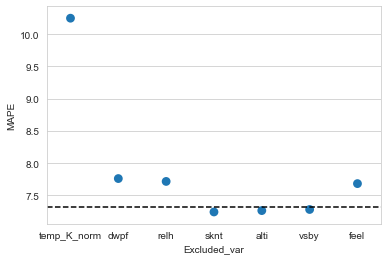

In [346]:
sns.set_style("whitegrid")
ax = sns.pointplot(x='Excluded_var', y='MAPE', data=mape_df, join = False)
ax.axhline(mape_all, ls='--', c = 'k')

Variablerna temperatur, dew point, relative humidity och feel ger högre mape än modellen med alla variabler inkluderade och bör alltså inkluderas. wind speed (sknt), pressure (alti) och visibility däremot ger lägre mape när de exkluderas.  
Testa att bygga en slutgiltig modell där dessa tre exkluderas.

In [347]:
prophet_with_vars(['temp_K_norm', 'dwpf', 'relh', 'feel'])

7.367353613909532

In [348]:
prophet_with_vars(['temp_K_norm', 'dwpf', 'relh', 'feel', 'sknt'])

7.272257285810821

In [349]:
prophet_with_vars(['temp_K_norm', 'dwpf', 'relh', 'feel', 'alti'])

7.3138665768345765

In [350]:
prophet_with_vars(['temp_K_norm', 'dwpf', 'relh', 'feel', 'vsby'])

7.3613542094945945

In [351]:
mape_all

7.326422006081788

In [358]:
import itertools

mapes_full_comparison = []
var_comb = []

for L in range(1, len(var_list_all)+1):
    for subset in itertools.combinations(var_list_all, L):
        var = list(subset)
        var_comb.append(var)
        print(var)
        mapes_full_comparison.append(prophet_with_vars(var))
        


['temp_K_norm']
['dwpf']
['relh']
['sknt']
['alti']
['vsby']
['feel']
['temp_K_norm', 'dwpf']
['temp_K_norm', 'relh']
['temp_K_norm', 'sknt']
['temp_K_norm', 'alti']
['temp_K_norm', 'vsby']
['temp_K_norm', 'feel']
['dwpf', 'relh']
['dwpf', 'sknt']
['dwpf', 'alti']
['dwpf', 'vsby']
['dwpf', 'feel']
['relh', 'sknt']
['relh', 'alti']
['relh', 'vsby']
['relh', 'feel']
['sknt', 'alti']
['sknt', 'vsby']
['sknt', 'feel']
['alti', 'vsby']
['alti', 'feel']
['vsby', 'feel']
['temp_K_norm', 'dwpf', 'relh']
['temp_K_norm', 'dwpf', 'sknt']
['temp_K_norm', 'dwpf', 'alti']
['temp_K_norm', 'dwpf', 'vsby']
['temp_K_norm', 'dwpf', 'feel']
['temp_K_norm', 'relh', 'sknt']
['temp_K_norm', 'relh', 'alti']
['temp_K_norm', 'relh', 'vsby']
['temp_K_norm', 'relh', 'feel']
['temp_K_norm', 'sknt', 'alti']
['temp_K_norm', 'sknt', 'vsby']
['temp_K_norm', 'sknt', 'feel']
['temp_K_norm', 'alti', 'vsby']
['temp_K_norm', 'alti', 'feel']
['temp_K_norm', 'vsby', 'feel']
['dwpf', 'relh', 'sknt']
['dwpf', 'relh', 'alti']
[

In [359]:
mape_df_all_comb = pd.DataFrame(list(zip(var_comb, mapes_full_comparison)), columns=['vars','MAPE'])

In [374]:
mape_df_all_comb['var_str'] = mape_df_all_comb['vars'].apply(lambda x: ', '.join(x))
mape_df_all_comb['N_vars'] = mape_df_all_comb['vars'].apply(lambda x: len(x))
mape_df_all_comb

,vars,MAPE,var_str,N_vars
0,[temp_K_norm],7.710728,temp_K_norm,1
1,[dwpf],12.178056,dwpf,1
2,[relh],14.062806,relh,1
3,[sknt],14.354858,sknt,1
4,[alti],14.115244,alti,1
...,...,...,...,...
122,"[temp_K_norm, dwpf, relh, alti, vsby, feel]",7.244572,"temp_K_norm, dwpf, relh, alti, vsby, feel",6
123,"[temp_K_norm, dwpf, sknt, alti, vsby, feel]",7.717999,"temp_K_norm, dwpf, sknt, alti, vsby, feel",6
124,"[temp_K_norm, relh, sknt, alti, vsby, feel]",7.762456,"temp_K_norm, relh, sknt, alti, vsby, feel",6
125,"[dwpf, relh, sknt, alti, vsby, feel]",10.248797,"dwpf, relh, sknt, alti, vsby, feel",6


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126]),
 <a list of 127 Text xticklabel objects>)

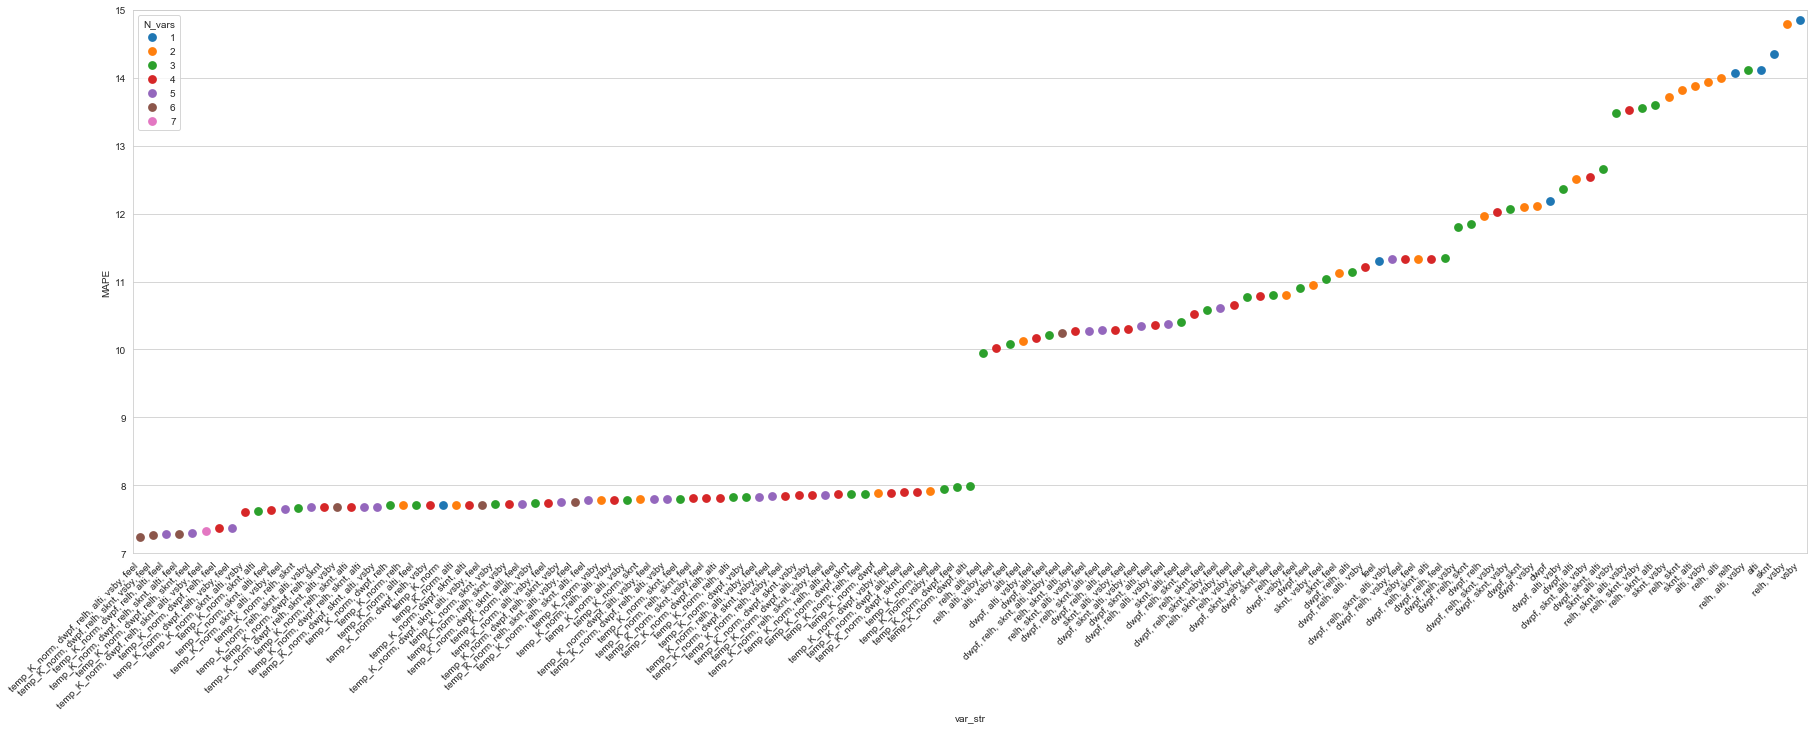

In [377]:
sns.set_style("whitegrid")
plt.figure(figsize=(30,10))
ax = sns.pointplot(x='var_str', y='MAPE', hue = 'N_vars', data=mape_df_all_comb.sort_values('MAPE'), join = False)
ax.set_ylim(7., 15.)
plt.xticks(rotation=45,horizontalalignment='right')

In [378]:
mape_df_all_comb.sort_values('MAPE').head(10)

,vars,MAPE,var_str,N_vars
122,"[temp_K_norm, dwpf, relh, alti, vsby, feel]",7.244572,"temp_K_norm, dwpf, relh, alti, vsby, feel",6
121,"[temp_K_norm, dwpf, relh, sknt, vsby, feel]",7.265853,"temp_K_norm, dwpf, relh, sknt, vsby, feel",6
102,"[temp_K_norm, dwpf, relh, alti, feel]",7.282308,"temp_K_norm, dwpf, relh, alti, feel",5
120,"[temp_K_norm, dwpf, relh, sknt, alti, feel]",7.283054,"temp_K_norm, dwpf, relh, sknt, alti, feel",6
100,"[temp_K_norm, dwpf, relh, sknt, feel]",7.295194,"temp_K_norm, dwpf, relh, sknt, feel",5
126,"[temp_K_norm, dwpf, relh, sknt, alti, vsby, feel]",7.326422,"temp_K_norm, dwpf, relh, sknt, alti, vsby, feel",7
66,"[temp_K_norm, dwpf, relh, feel]",7.367354,"temp_K_norm, dwpf, relh, feel",4
103,"[temp_K_norm, dwpf, relh, vsby, feel]",7.370041,"temp_K_norm, dwpf, relh, vsby, feel",5
79,"[temp_K_norm, sknt, alti, vsby]",7.605529,"temp_K_norm, sknt, alti, vsby",4
37,"[temp_K_norm, sknt, alti]",7.615983,"temp_K_norm, sknt, alti",3


15.31 är mape för modell utan extra regressor, ingen kombination av regressorer är sämre än det. De första 8 kombinationerna har ganska lika mape och vid kombination 9 sker ett litet "hopp", vad hände där? De första 8 i topplistan har temp_K_norm, dwpf, feel, relh gemensamt med vissa alti, vsby och sknt

In [389]:
rmse = []
for var in mape_df_all_comb.sort_values('MAPE').head(10)['vars']:
    print(var)
    rmse.append(prophet_with_vars(var, error = 'RMSE'))


['temp_K_norm', 'dwpf', 'relh', 'alti', 'vsby', 'feel']
['temp_K_norm', 'dwpf', 'relh', 'sknt', 'vsby', 'feel']
['temp_K_norm', 'dwpf', 'relh', 'alti', 'feel']
['temp_K_norm', 'dwpf', 'relh', 'sknt', 'alti', 'feel']
['temp_K_norm', 'dwpf', 'relh', 'sknt', 'feel']
['temp_K_norm', 'dwpf', 'relh', 'sknt', 'alti', 'vsby', 'feel']
['temp_K_norm', 'dwpf', 'relh', 'feel']
['temp_K_norm', 'dwpf', 'relh', 'vsby', 'feel']
['temp_K_norm', 'sknt', 'alti', 'vsby']
['temp_K_norm', 'sknt', 'alti']


In [388]:
mape_df_all_comb.sort_values('MAPE').head(10)

,vars,MAPE,var_str,N_vars
122,"[temp_K_norm, dwpf, relh, alti, vsby, feel]",7.244572,"temp_K_norm, dwpf, relh, alti, vsby, feel",6
121,"[temp_K_norm, dwpf, relh, sknt, vsby, feel]",7.265853,"temp_K_norm, dwpf, relh, sknt, vsby, feel",6
102,"[temp_K_norm, dwpf, relh, alti, feel]",7.282308,"temp_K_norm, dwpf, relh, alti, feel",5
120,"[temp_K_norm, dwpf, relh, sknt, alti, feel]",7.283054,"temp_K_norm, dwpf, relh, sknt, alti, feel",6
100,"[temp_K_norm, dwpf, relh, sknt, feel]",7.295194,"temp_K_norm, dwpf, relh, sknt, feel",5
126,"[temp_K_norm, dwpf, relh, sknt, alti, vsby, feel]",7.326422,"temp_K_norm, dwpf, relh, sknt, alti, vsby, feel",7
66,"[temp_K_norm, dwpf, relh, feel]",7.367354,"temp_K_norm, dwpf, relh, feel",4
103,"[temp_K_norm, dwpf, relh, vsby, feel]",7.370041,"temp_K_norm, dwpf, relh, vsby, feel",5
79,"[temp_K_norm, sknt, alti, vsby]",7.605529,"temp_K_norm, sknt, alti, vsby",4
37,"[temp_K_norm, sknt, alti]",7.615983,"temp_K_norm, sknt, alti",3
